# Imports

In [1]:
import pandas as pd
from coordinate_matching import *

# Code

# Example 1: Artificial data

Will generate random ra and dec values for the 1st table. The second table will have 1/4th of the same ra and dec values, but shifted slightly (we want to recover those). They are shifted by adding a Gaussian with mean = 0 and stdev = 0.5 arcsec. We add more targets with random coordinates to the 2nd table, so that both tables have the same amount of entries.

###### Generate data

In [2]:
n = 800
ra1, dec1 = np.random.uniform(150, 250, n), np.random.uniform(20, 40, n)


ra2 = list(ra1[:int(n/4)] + np.random.normal(0,0.5/3600,int(n/4))) + list(np.random.uniform(150, 250, int(n-n/4)))
dec2 = list(dec1[:int(n/4)] + np.random.normal(0,0.5/3600,int(n/4))) + list(np.random.uniform(20, 40, int(n-n/4)))


df1 = pd.DataFrame({'ra':ra1,'dec':dec1})
df2 = pd.DataFrame({'ra':ra2,'dec':dec2})

###### Visualise on sky

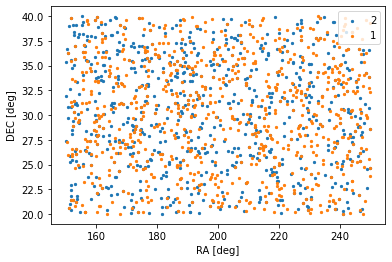

In [3]:
plot_on_sky([df1['ra'],df1['dec']],[df2['ra'],df2['dec']], markersize = 5, alpha = 1)

###### Determine appropriate separation limit

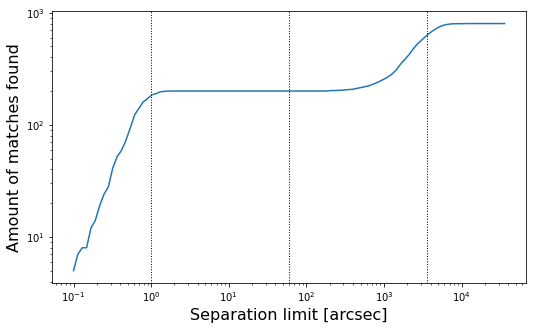

In [4]:
plot_separation_limit([df1['ra'],df1['dec']],[df2['ra'],df2['dec']], logscale = True)

In the plot above, you see that the amount of matches increases significantly until a separation limit of ~1 arcsec. This makes sense, as the targets were shifted by added a Gaussian with a stdev of 0.5 arcsec. After that, the amount of matches stagnates until we hit ridiculous values of separation limit (on the scale of 10's of arcmin). After that, the separation limit goes up again, because we are sweeping up all remaining targets. 

Note that the dotted vertical lines are set at 1 arcsec, 1 arcmin and 1 degree.

We can zoom in by turning off logscale and add values for xmin and xmax:

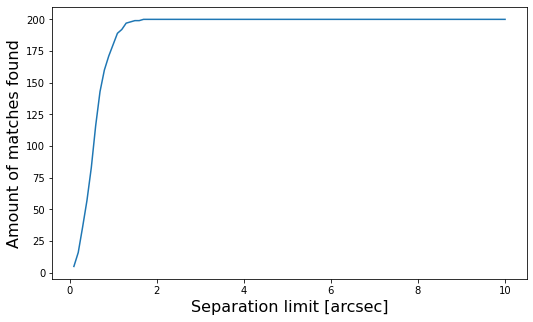

In [5]:
plot_separation_limit([df1['ra'],df1['dec']],[df2['ra'],df2['dec']], xmin = 0.1, xmax = 10)

Seems like a separation limit of ~2 arcsec seems appropriate for this data. Less than that, we start to loose targets. Setting it a bit higher won't change much, as the amount of matches stagnates.

###### Find actual matches

In [6]:
idx, _, _ = match_catalogs([df1['ra'],df1['dec']],[df2['ra'],df2['dec']], limit = 2) # limit can vary, depending on how conservative you want to be.



In [7]:
# TODO: put this in function too

df2 = df2.reset_index()

# Remove all where idx is np.nan, so no match found.
ind_selection = np.where(np.isnan(idx))[0]
df1 = df1.drop(ind_selection,axis=0)
df1 = df1.reset_index(drop=True)
idx_denan = [int(i) for i in idx if ~np.isnan(i)]

# Match data to it
df1['index'] = list(df2['index'][idx_denan])
df_merged = df1.merge(df2,left_on='index',right_on='index', how='inner', suffixes = ('1','2'))
df_merged = df_merged.drop(columns=['index'])
print('We have ' + str(len(df_merged))+ ' galaxies left.') #12509

We have 200 galaxies left.


We return 200 galaxies, as expected.

###### Verify differences in coordinates

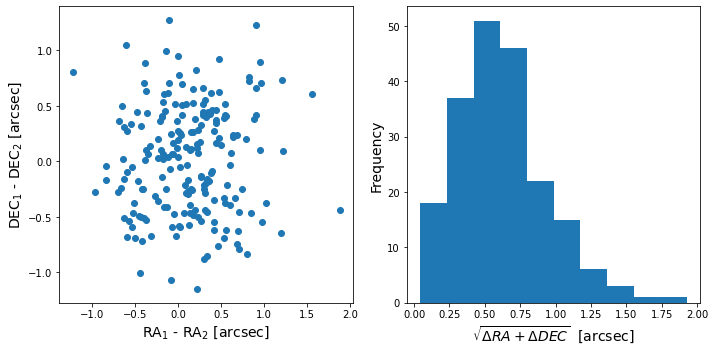

In [8]:
plot_coordinate_difference([df_merged['ra1'], df_merged['dec1']], [df_merged['ra2'], df_merged['dec2']])

Most targets have ~0.5 arcsec difference, as expected. 

# Example 2: Real data

We will match MaNGA with Galaxy Zoo DECaLS on their coordinates. I obtained the MaNGA coordinates from MaNGA drpall, DR17 (https://www.sdss.org/dr17/manga/). The Galaxy Zoo DECaLS coordinates can be found here (https://arxiv.org/abs/2102.08414). Both were taken at 4 Oct 2022.

Important: it is very strongly advised that you use the smaller catalog as catalog_A (as in the example below). This will significantly speed up the matching process. 

###### Load the data

In [9]:
df_manga = pd.read_csv('data/manga_coordinates.csv')
df_gz = pd.read_csv('data/gzdecals_coordinates.csv')

print(f'There are {len(df_manga)} galaxies in the MaNGA table and {len(df_gz)} galaxies in the Galaxy Zoo table.')

There are 11273 galaxies in the MaNGA table and 313789 galaxies in the Galaxy Zoo table.


###### Visualise on sky

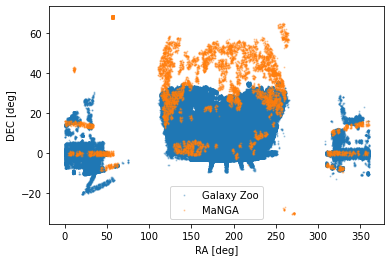

In [10]:
plot_on_sky([df_manga['objra'],df_manga['objdec']],
            [df_gz['ra'],df_gz['dec']], 
            labels = ['MaNGA','Galaxy Zoo'])

###### Determine appropriate separation limit

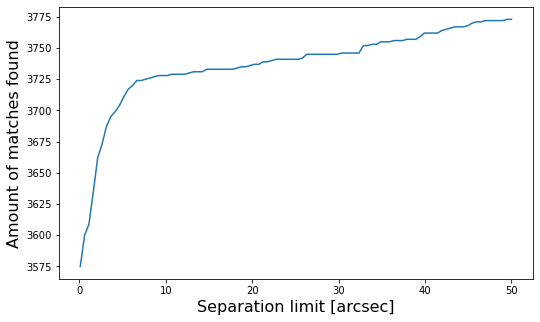

In [11]:
plot_separation_limit([df_manga['objra'],df_manga['objdec']],
                       [df_gz['ra'],df_gz['dec']])

Ideal separation limit seems to be around ~5 arcsec.

###### Find actual matches

In [12]:
idx, _, _= match_catalogs([df_manga['objra'],df_manga['objdec']],
                          [df_gz['ra'],df_gz['dec']],
                          limit = 5) # limit can vary, depending on how conservative you want to be.



NameError: name 'd3d_temp' is not defined

In [ ]:
# TODO: put this in function too

df_gz = df_gz.reset_index()

# Remove all where idx is np.nan, so no match found.
ind_selection = np.where(np.isnan(idx))[0]
df_manga = df_manga.drop(ind_selection,axis=0)
df_manga = df_manga.reset_index(drop=True)
idx_denan = [int(i) for i in idx if ~np.isnan(i)]

# Match data to it
df_manga['index'] = list(df_gz['index'][idx_denan])
df_merged = df_manga.merge(df_gz,left_on='index',right_on='index', how='inner', suffixes = ('_manga','_gz'))
df_merged = df_merged.drop(columns=['index'])
print('We have ' + str(len(df_merged))+ ' galaxies left.') #12509

###### Verify differences in coordinates

In [ ]:
plot_coordinate_difference([df_merged['ra'], df_merged['dec']], 
                           [df_merged['objra'], df_merged['objdec']],
                           labels = ['MaNGA','Galaxy Zoo'])

TODO: For these tables, we can also just match on iauname. We miss a couple of targets while coordinate matching. Check why not a perfect match. But my guess: some 'true' matches might fall outside the limit that we chose. Alternatively, some are matched incorrectly, because another target happened to be closer by. Nothing that we can do about this, unfortunately.